In [1]:
# import the libraries

import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# visualization function

def  show(tensor, ch=1, size=(28,28), num=16):

  #tensor: 128 x 784
  data=tensor.detach().cpu().view(-1,ch,*size)
  grid = make_grid(data[:num], nrow=4).permute(1,2,0)
  plt.imshow(grid)
  plt.show()

In [3]:
# setup of the main parameters and hyperparameter
epochs = 200
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=bs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
from torch.nn.modules.batchnorm import BatchNorm1d
# declare our models

#Generator
def genBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim),
        genBlock(h_dim, h_dim*2),
        genBlock(h_dim*2, h_dim*4),
        genBlock(h_dim*4, h_dim*8),
        nn.Linear(h_dim*8, i_dim),
        nn.Sigmoid(),
    )

  def forward(self, noise):
      return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)


  # Discriminator
def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim, h_dim*4),
        discBlock(h_dim*4, h_dim*2),
        discBlock(h_dim*2, h_dim),
        nn.Linear(h_dim, 1)
    )

  def forward(self, image):
      return self.disc(image)

In [5]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([4, 8, 6, 3, 3, 0, 8, 4, 4, 2])


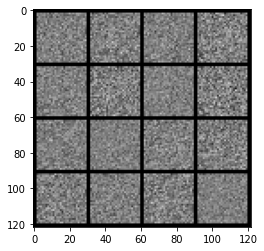

In [6]:
x,y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)